# OceanPack
We use a short excerpt of real underwater CO2 measurements to demonstrate the routines in the `oceanpack` module.

### read file
First, read the file into a pd.DataFrame and show head and variable names.
> The `read_oceanpack()` routine can be fed with either a single file path or a list of file paths.

In [143]:
from oceanpack import *

file = 'example_op.log'
df = read_oceanpack(file)

print(df.iloc[:,:6].head())
print(df.columns)

                     FRAC    SEC      CO2    CO2abs      H2O    H2Oabs
DATE_TIME                                                             
2019-05-09 13:00:00     0  11530  324.070  0.079997  13.2548  0.086408
2019-05-09 13:00:10     0  11540  324.191  0.080007  13.2614  0.086425
2019-05-09 13:00:20     0  11550  324.126  0.080019  13.2564  0.086426
2019-05-09 13:00:30     0  11560  324.335  0.080061  13.2586  0.086441
2019-05-09 13:00:40     0  11570  324.320  0.080070  13.2580  0.086449
Index(['FRAC', 'SEC', 'CO2', 'CO2abs', 'H2O', 'H2Oabs', 'H2Odew', 'CellTemp',
       'CellPress', 'VInput', 'CO2raw', 'CO2ref', 'H2Oraw', 'H2Oref',
       'H2OzCal', 'CO2zCal', 'Span1Cal', 'Span2Cal', 'SWVers', 'CO2kzero',
       'CO2kspan1', 'CO2kspan2', 'H2Okzero', 'AIN3_mA/Waterflow', 'FLOWgas',
       'TempAirInt', 'DPressInt', 'Latitude', 'Longitude', 'Speed', 'Course',
       'Magn.Var', 'GPS Time', 'waterTemp', 'waterCond', 'pvuaVin', 'pvuaVout',
       'pvuaPuff', 'pvuaIout', 'PUMP', 'VALVE

> Hint: Depending on the version of the OceanPack not all of the for the following calculations required variables are stored in the log files of the analyzer.
> It might be necessary to combine datasets both from the Analyzer as well as from the NetDI unit.
> Both files can be usually read by `read_oceanpack()` and might be combined, for example, via
>
> ```
> df_combined = pd.merge_asof(data_netdi.sort_index(), data_analyzer.sort_index(),
>                             left_index=True, right_index=True,
>                             tolerance=pd.Timedelta('2min'), direction='nearest')
> ```

### Convert coordinates
Convert coordinates in 'ddmm.mmmm' format into 'dd.dddd'.

In [144]:
print(df['Longitude'].tail(3))
print('\nConvert coordinates...\n')
df['Longitude'] = decimal_degrees(df['Longitude'])
df['Latitude'] = decimal_degrees(df['Longitude'])
print(df['Longitude'].tail(3))

DATE_TIME
2019-05-09 18:30:40   -453.1092
2019-05-09 18:30:50   -453.1395
Name: Longitude, dtype: float64

Convert coordinates...

DATE_TIME
2019-05-09 18:30:40   -4.885153
2019-05-09 18:30:50   -4.885658
Name: Longitude, dtype: float64


### Compute pressure at equilibrator
The OceanPack only measures the pressure at the analyzer cell ($p_\text{cell}$) as well as the pressure difference $p_\text{diff}$ at the intake.
To retrieve the pressure at the equilibrator ($p_\text{equ}$), we build a moving average of the difference pressure
(to smooth the fluctuations) and add this on the cell pressure.
Finally, we convert the pressure into atm units.

In [148]:
pressure_equ = df['CellPress'] + df['DPressInt'].rolling('1min').mean()  # in mBar
df['press_equ'] = pressure2atm(pressure_equ)


Pressure is assumed to be in hPa and was converted to atm


> Hint: The routine `pressure2atm()` tries to guess the input unit by hands of the order of magnitude of the input values.
If this doesn't work (check the info message above), convert it by hand.

### Filter non-operating phases
Usually, the OceanPack runs through various phases (such as spin-up, calibration, normal operation).
For our final calculation we want to get rid of all the CO2 related values in non-operating phases and also skip the first x minutes after each non-operating phase is finished,
since after calibration, the analyzer usually needs some time to get back to normal levels.

In [135]:
df = set_nonoperating_to_nan(df, col=[x for x in df.columns if 'CO2' in x], shift="20min")

### CO2 calculations
Now, after all the preparation is done, let's calculate our CO2 variables of interest.

First, we need to convert the xCO2 concentration, which is given by the analyzer, into partial pressure.

According to Dickson et al. (2007), SOP 4, the partial pressure of carbon dioxide in air, which is in equilibrium with a sample of sea water, is defined as the product of the mole fraction of CO2 in the equilibrated gas phase and the total pressure of equilibration $p_\text{equ}$:

\begin{equation*}
pCO_2 = xCO_2 \cdot p_\text{equ}
\end{equation*}

In [149]:
df['pCO2_wet_equ'] = ppm2uatm(df['CO2'], df['press_equ'])


Pressure is assumed to be already in atm (no conversion)


Second, we want to apply a temperature correction.
The correction follows Takahashi et al. (2009):

\begin{equation*}
{(xCO_2)}_{SST} = {(xCO_2)}_{T_\text{equ}} \cdot \exp{\Big(0.0433\cdot(SST - T_\text{equ}) - 4.35\times 10^{-5}\cdot(SST^2 - T_\text{equ}^2)\Big)}
\end{equation*}

For demonstration purposes, we create an artificial SST, which is slightly cooler than the water temperature measured at the equilibrator.

In [150]:
df['insituTemp'] = df['waterTemp'] - .2
df['pCO2_wet_sst'] = temperature_correction(df['pCO2_wet_equ'], df['waterTemp'], df['insituTemp'])

Finally, we can compute the fugacity by hands of the before calculated partial pressure, the pressure at the equilibrator and the SST.

According to Weiss (1974), the fugacity can be calculated via

\begin{equation*}
(fCO_2)^\text{wet}_\text{SST} = (pCO_2)^\text{wet}_\text{SST} \cdot
        \exp{\Big(p_\text{equ}\cdot\frac{\left[ B(CO_2,SST) + 2\,\left(1-(xCO_2)^\text{wet}_{SST}\right)^2 \, \delta(CO_2,SST)\right]}{R\cdot SST}\Big)}
\end{equation*}

where $SST$ is the sea surface temperature in K, $R$ the gas constant and $B(CO_2,SST)$ and $\delta(CO_2,SST)$ are the virial coefficients for CO2 (both in $cm^3\,mol^{-1}$), which are given as

\begin{equation*}
B(CO_2,T) = -1636.75 + 12.0408\,T - 0.0327957\,T^2 + 0.0000316528\,T^3
\end{equation*}

and

\begin{equation*}
\delta(CO_2,T) = 57.7 - 0.188\,T
\end{equation*}

In [151]:
df['fCO2_wet_sst'] = fugacity(df['pCO2_wet_sst'], df['press_equ'], df['insituTemp'])



Pressure is assumed to be already in atm (no conversion)


### Plot the results

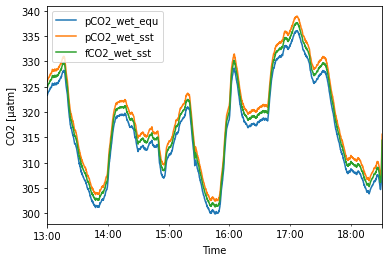

In [152]:
import matplotlib.pyplot as plt
df['pCO2_wet_equ'].plot()
df['pCO2_wet_sst'].plot()
df['fCO2_wet_sst'].plot()
plt.legend()
plt.xlabel('Time')
plt.ylabel('CO2 [µatm]')
plt.show()